# uploading data

In [3]:
#from PIL import ImageOps
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import xmltodict
from numcodecs import Blosc
import numpy as np
import zarr as zarr
import tifffile as tf
from PIL import Image as im
import cv2
from skimage.io import imread
from skimage.exposure import cumulative_distribution #calculate the cumulative pixel value
import imagecodecs
from google.colab.patches import cv2_imshow
from skimage import exposure
from skimage.exposure import match_histograms

# histogram matching

In [5]:
polaris=tf.imread('/content/drive/MyDrive/ITMO/Color_project/polaris.tif')
#huron_ihc=tf.imread('/content/drive/MyDrive/ITMO/Color_project/huron_IHC.tif')
#huron_ihc=tf.imread('/content/drive/MyDrive/ITMO/Color_project/huron_IHC_101010.tif')
huron_111219=tf.imread('/content/drive/MyDrive/ITMO/Color_project/huron_IHC_111219.tif')

In [6]:
polaris_a1=polaris[455:590, 100:235, :]
#plt.imshow(polaris_a1)

In [7]:
huron_a1=huron_ihc[304:437, 65:198, :]
#plt.imshow(huron_a1)

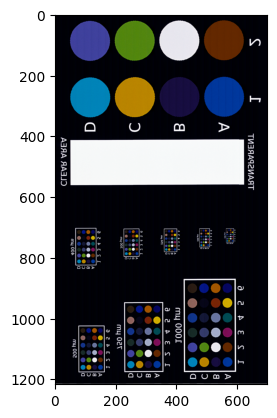

In [29]:
plt.imshow(huron_111219)

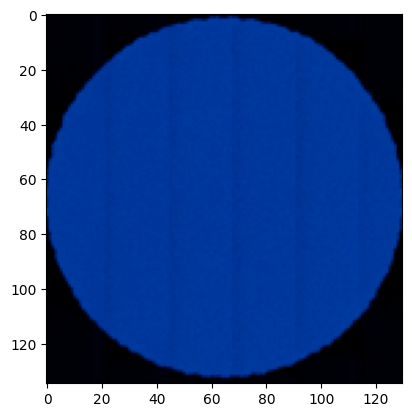

In [34]:
huron_a1_3gammas=huron_111219[205:340, 490:620, :]
#plt.imshow(huron_a1_3gammas)

In [ ]:
#convert images to grayscale
polaris_gray=cv2.cvtColor(polaris_a1, cv2.COLOR_BGR2GRAY)
huron_gray=cv2.cvtColor(huron_a1, cv2.COLOR_BGR2GRAY)

In [ ]:
#creating circle mask for gs image
def masking(img):
  img_circle=np.around(cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.5, 50)).astype(np.uint8) #finds circle on an image
  coord=img_circle[0][0] #gets 1d x,y,r coordinates from 3d array from the previous step
  mask = np.zeros_like(img) #creates empty array with a shape of the image
  cv2.circle(mask, (coord[0], coord[1]), coord[2], 255, -1) #applying a mask to the image

  return mask

In [ ]:
img_mask=masking(polaris_gray)

In [ ]:
masked_polaris = np.where(img_mask == 255, polaris_gray, 0)
masked_huron = np.where(img_mask == 255, huron_gray, 0)

In [ ]:
counts_pol, bins_pol = np.histogram(masked_polaris[img_mask == 255], bins=256, range=(0, 256))
counts_huron, bins_hur = np.histogram(masked_huron[img_mask == 255], bins=256, range=(0, 256))

In [ ]:
#masked_image = cv2.bitwise_and(polaris_gray, polaris_gray, mask=img_mask)

In [ ]:
bins_pol=bins_pol[:-1].astype(np.uint8)
bins_hur=bins_hur[:-1].astype(np.uint8)

# testing

In [ ]:
polaris_gs=polaris_a1.mean(axis=2).astype(np.uint8)
huron_gs=huron_a1.mean(axis=2).astype(np.uint8)

In [ ]:
#creating 1d arrays
#polaris_flatten = polaris_a1.mean(axis=2).flatten()
polaris_flatten = polaris_gs.flatten()
huron_flatten = huron_gs.flatten()

In [ ]:
counts_pol, bins = np.histogram(polaris_flatten, 256, [0,256])
counts_huron, _ = np.histogram(huron_flatten, 256, [0,256])

In [ ]:
counts_pol, bins = np.histogram(polaris_gray, 256, [0,256])

In [ ]:
bins=bins[:-1]

In [ ]:
def get_cdf(counts):
  cdf=counts.cumsum().astype(np.float64)
  cdf/=cdf.max().astype(np.float64)

  return cdf

In [ ]:
cdf_polaris=get_cdf(counts_pol)

In [ ]:
cdf_huron=get_cdf(counts_huron)

In [ ]:
lut=np.interp(cdf_polaris, cdf_huron, bins).astype(np.uint8)

In [ ]:
import pandas as pd
pd.DataFrame(lut)

,0
0,0
1,0
2,0
3,0
4,0
...,...
251,255
252,255
253,255
254,255


In [ ]:
huron_matched=cv2.LUT(polaris_gs, lut)

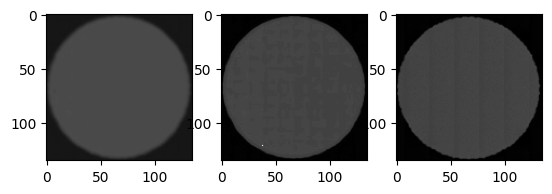

In [ ]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(polaris_gs,cmap='gray', vmin=0, vmax=255)
axs[1].imshow(huron_matched,cmap='gray', vmin=0, vmax=255)
axs[2].imshow(huron_gs,cmap='gray', vmin=0, vmax=255)

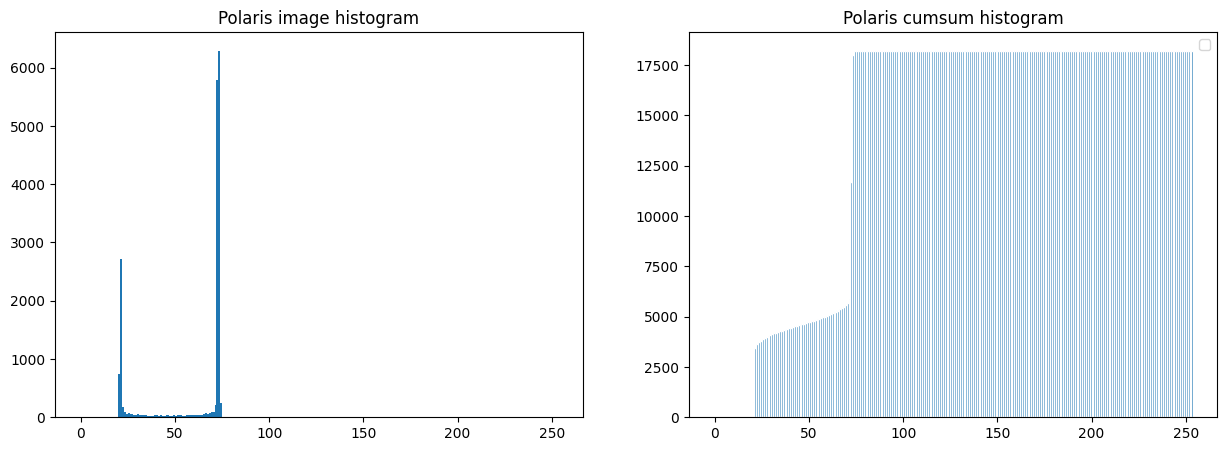

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(bins[:-1] - 0.5, counts_pol, width=1, edgecolor='none')
axs[0].set_title('Polaris image histogram')

axs[1].bar(bins[:-1] - 0.5, counts_cs_pol, width=1, edgecolor='white')
axs[1].set_title('Polaris cumsum histogram')
axs[1].legend()
plt.subplots_adjust(wspace=0.2)
plt.show()

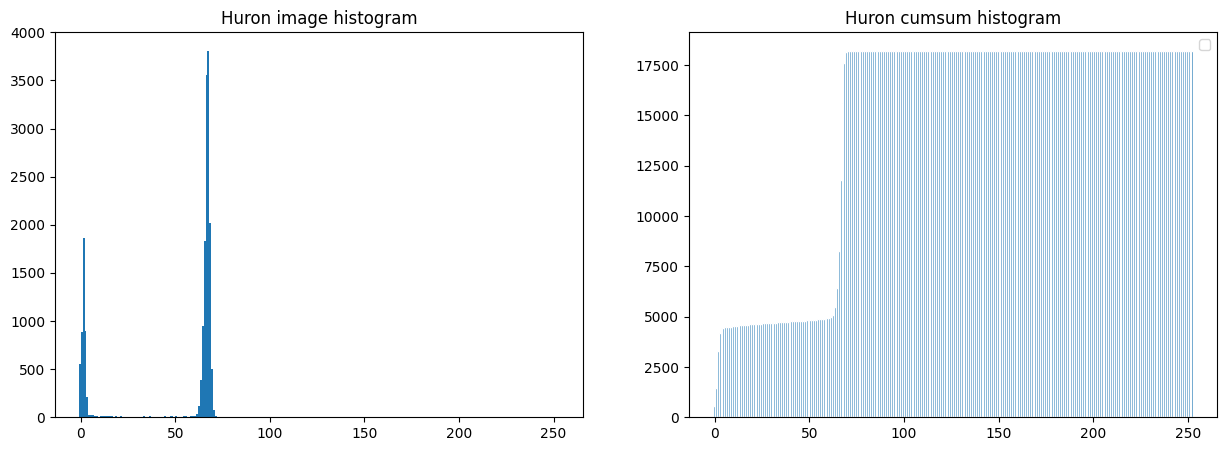

In [ ]:
counts_huron, bins = np.histogram(huron_flatten, range(255))
counts_cs_huron=np.cumsum(counts_huron)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(bins[:-1] - 0.5, counts_huron, width=1, edgecolor='none')
axs[0].set_title('Huron image histogram')

axs[1].bar(bins[:-1] - 0.5, counts_cs_huron, width=1, edgecolor='white')
axs[1].set_title('Huron cumsum histogram')
axs[1].legend()
plt.subplots_adjust(wspace=0.2)
plt.show()

In [ ]:
def nearest_neighbor(pixel_value, target_image_hist):
  matched_pixel=np.where(target_image_hist == pixel_value)[0]
  if len(matched_pixel)==0:
    nearest_value= np.argmin(np.abs(np.array(target_image_hist) - pixel_value))
    return nearest_value
  else:
    return matched_pixel[0]

def histogram_matching(source_hist, ref_hist):
  modified_hist=np.zeros_like(source_hist, dtype=int)
  bins = np.arange(256)
  for i in range(len(source_hist)):
    modified_hist[i]=nearest_neighbor(pixel_value=source_hist[i], target_image_hist=ref_hist)
  cdf=np.cumsum(modified_hist)
  plt.bar(bins[:-1] - 0.5, cdf, width=1, color='red')
  plt.xlim([-0.5, 255.5])
  plt.show()

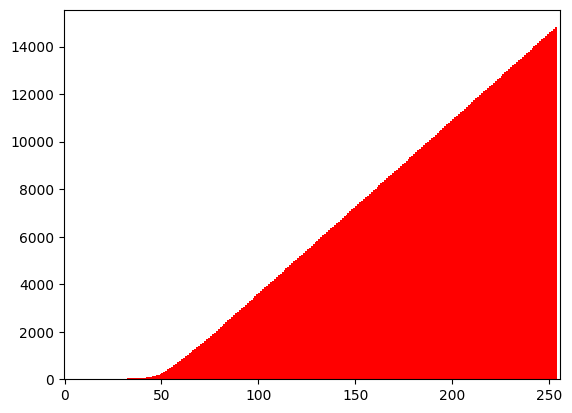

In [ ]:
histogram_matching(counts_cs_pol, counts_cs_huron)

In [ ]:
cv2.LUT

# gammas

In [ ]:
#huron_red=huron_a1[:,:,0]
#huron_green=huron_a1[:,:,1]
#huron_blue=huron_a1[:,:,2]
#np.where(v>= 0.04045,((v + 0.055) / 1.055)**2.4, v/12.92)

In [55]:
#transformation to non-linear image
#huron_norm=huron_a1/255
#huron_sRGB=huron_norm**(1/2.2)
#huron_corrected=(huron_sRGB*255).astype(np.uint8)

In [110]:
#transfer function
def transfer_function(img, values, mode='linearization'):
  '''
  This function takes the image and performs transformation based on two modes: default 'linearization' outputs image with 1.0 gamma,
  any other mode (e.g. 'correction') applies gamma(s) to an image. Single float/int number or list of numbers can be inputed
  as 'values' parameter
  '''

  img_norm=img/255.0 #converts array values from 0-255 range to 0-1
  if isinstance(values, (float, int)): #this part is needed to handle both single numbers and a list of gammas
    values = [values]
  if len(values)!=1:
    transposed=np.transpose(img_norm, (2,0,1)) #dimension with color channels becomes the first in order
    modified=np.empty_like(transposed)
    for i, gamma in enumerate(values):
      modified[i]=transposed[i]**(gamma if mode == 'linearization' else 1/gamma)
    modified=np.transpose(modified, (1,2,0))
  else:
    gamma = values[0]
    modified=img_norm**(gamma if mode == 'linearization' else 1/gamma)

  modified=(modified*255).astype(np.uint8)
  plt.imshow(modified)
  return modified